## Final Project: Politifact Analysis

**GROUP: Forhad Akbar, Adam Douglas, and Soumya Ghosh**

### Introduction
The website www.politifact.com is a non-partisan fact-checking website that dedicates itself to countering false and misleading political information $^1$. Politifact uses human fact-checkers to research statements made by politicians or viral media that states a political viewpoint. The fact-checker (also known as a "curtor") assigns a score for the item: True, Mostly True, Half True, Mostly False, False, and the dreaded "Pants On Fire" for the biggest falsehoods. The specifics of their research are also included to provide detail and sources related to their scoring.

### The Data
The data was sourced from the Kaggle web site $^2$ and contains 19,421 records. The items date from  to .

### Goal
The goal of this analysis is to use NLP techniques on the curator's review to categorize the topics of the record (e.g. budget, coronavirus, election, etc.). Once topics have been assigned to each record, a network analysis of sources will be done to analyze patterns of false information by topic (e.g. politician X frequently puts out more misleading/false information on topic Y than any other).

### Analysis
#### Data Loading and Cleansing

First we will load the data from the CSV file and then prepare the data for analysis.

In [2]:
pol = pd.read_csv("politifact.csv", index_col = 0, usecols = range(0,11))
pol.head()

,sources,sources_dates,sources_post_location,sources_quote,curator_name,curated_date,fact,sources_url,curators_article_title,curator_complete_article
0,Viral image,2021-03-20 00:00:00,a Facebook post:\n,\nSays Disneyland is enforcing a “no scream” p...,Ciara O'Rourke,2021-03-22 00:00:00,false,https://www.politifact.com/factchecks/2021/mar...,"\nNo, Disneyland isn’t enforcing a ‘no scream’...",\nBack in July a Japanese amusement park drew ...
1,Viral image,2021-01-24 00:00:00,a Facebook post:\n,\nVideo “proves 100% that President Joe Biden ...,Ciara O'Rourke,2021-03-22 00:00:00,pants-fire,https://www.politifact.com/factchecks/2021/mar...,"\nNo, this video doesn’t prove Biden isn’t hum...",\nA recent Facebook post uses a video clip of ...
2,Terry McAuliffe,2021-03-10 00:00:00,a speech:\n,\n“If you look at the average teacher pay comp...,Warren Fiske,2021-03-22 00:00:00,true,https://www.politifact.com/factchecks/2021/mar...,\nVa. teachers pay ranks last in U.S. compared...,"\n""If you look at the average teacher pay comp..."
3,TikTok posts,2021-03-17 00:00:00,a video caption:\n,\n“You will need a WHO Yellow Vaccination Pass...,Daniel Funke,2021-03-22 00:00:00,barely-true,https://www.politifact.com/factchecks/2021/mar...,"\nNo, you don’t need a WHO vaccination certifi...",\nA popular TikTok video said that if you want...
4,Mike Bost,2021-03-15 00:00:00,a radio,\nThe American Rescue Plan Act “does not” incl...,Kiannah Sepeda-Miller,2021-03-21 00:00:00,half-true,https://www.politifact.com/factchecks/2021/mar...,\nDoes the American Rescue Plan limit how stat...,\nAfter failing to stop the $1.9 trillion COVI...


In [3]:
# Remove newlines
pol["sources_post_location"] = pol["sources_post_location"].str.replace("\n"," ", regex = False)
pol["sources_quote"] = pol["sources_quote"].str.replace("\n"," ", regex = False)
pol["curators_article_title"] = pol["curators_article_title"].str.replace("\n"," ", regex = False)
pol["curator_complete_article"] = pol["curator_complete_article"].str.replace("\n"," ", regex = False)

pol.head()

,sources,sources_dates,sources_post_location,sources_quote,curator_name,curated_date,fact,sources_url,curators_article_title,curator_complete_article
0,Viral image,2021-03-20 00:00:00,a Facebook post:,Says Disneyland is enforcing a “no scream” po...,Ciara O'Rourke,2021-03-22 00:00:00,false,https://www.politifact.com/factchecks/2021/mar...,"No, Disneyland isn’t enforcing a ‘no scream’ ...",Back in July a Japanese amusement park drew a...
1,Viral image,2021-01-24 00:00:00,a Facebook post:,Video “proves 100% that President Joe Biden i...,Ciara O'Rourke,2021-03-22 00:00:00,pants-fire,https://www.politifact.com/factchecks/2021/mar...,"No, this video doesn’t prove Biden isn’t human",A recent Facebook post uses a video clip of a...
2,Terry McAuliffe,2021-03-10 00:00:00,a speech:,“If you look at the average teacher pay compa...,Warren Fiske,2021-03-22 00:00:00,true,https://www.politifact.com/factchecks/2021/mar...,Va. teachers pay ranks last in U.S. compared ...,"""If you look at the average teacher pay compa..."
3,TikTok posts,2021-03-17 00:00:00,a video caption:,“You will need a WHO Yellow Vaccination Passp...,Daniel Funke,2021-03-22 00:00:00,barely-true,https://www.politifact.com/factchecks/2021/mar...,"No, you don’t need a WHO vaccination certific...",A popular TikTok video said that if you want ...
4,Mike Bost,2021-03-15 00:00:00,a radio,The American Rescue Plan Act “does not” inclu...,Kiannah Sepeda-Miller,2021-03-21 00:00:00,half-true,https://www.politifact.com/factchecks/2021/mar...,Does the American Rescue Plan limit how state...,After failing to stop the $1.9 trillion COVID...


In [4]:
pol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19422 entries, 0 to 19421
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   sources                   19422 non-null  object
 1   sources_dates             19099 non-null  object
 2   sources_post_location     19261 non-null  object
 3   sources_quote             19422 non-null  object
 4   curator_name              19400 non-null  object
 5   curated_date              19333 non-null  object
 6   fact                      19422 non-null  object
 7   sources_url               19422 non-null  object
 8   curators_article_title    19417 non-null  object
 9   curator_complete_article  19376 non-null  object
dtypes: object(10)
memory usage: 1.6+ MB


In [5]:
pol.describe()

,sources,sources_dates,sources_post_location,sources_quote,curator_name,curated_date,fact,sources_url,curators_article_title,curator_complete_article
count,19422,19099,19261,19422,19400,19333,19422,19422,19417,19376
unique,4395,4378,4437,19396,521,3970,9,19421,19395,19353
top,Facebook posts,2020-11-04 00:00:00,an,On changing the rules for filibusters on pres...,Louis Jacobson,2020-02-20 00:00:00,false,https://www.politifact.com/factchecks/2011/oct...,Milwaukee County executive candidate Chris Ab...,A doppelganger is a ghostly double of a livi...
freq,1250,30,1953,3,1773,19,4556,2,4,4


## Check the most frequent words in the data

In [46]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

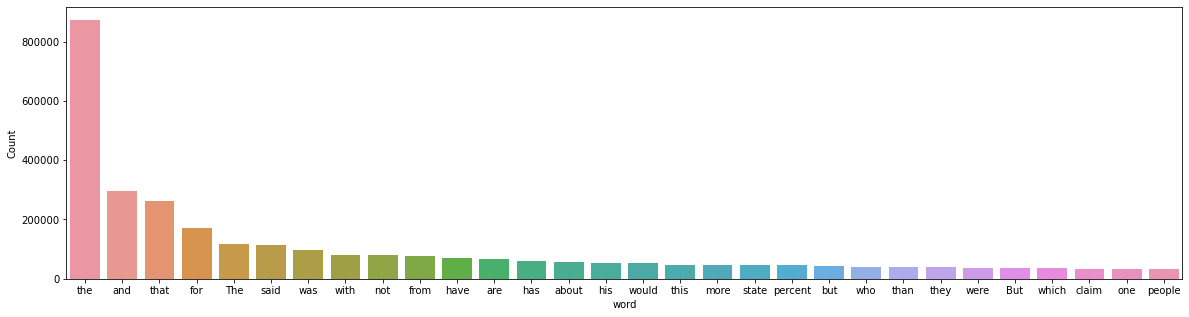

In [47]:
freq_words(pol['curator_complete_article'])

Let’s try to remove the stopwords and short words (<2 letters) from the articles

In [15]:
# remove unwanted characters, numbers and symbols
pol['curator_complete_article'] = pol['curator_complete_article'].str.replace("[^a-zA-Z#]", " ")

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\forhad\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [17]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [32]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
pol['curator_complete_article']= pol['curator_complete_article'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
pols = [remove_stopwords(r.split()) for r in pol['curator_complete_article']]

# make entire text lowercase
pols = [r.lower() for r in pols]

Let’s again plot the most frequent words and see if the more significant words have come out.

In [ ]:
Let’s again plot the most frequent words and see if the more significant words have come out.

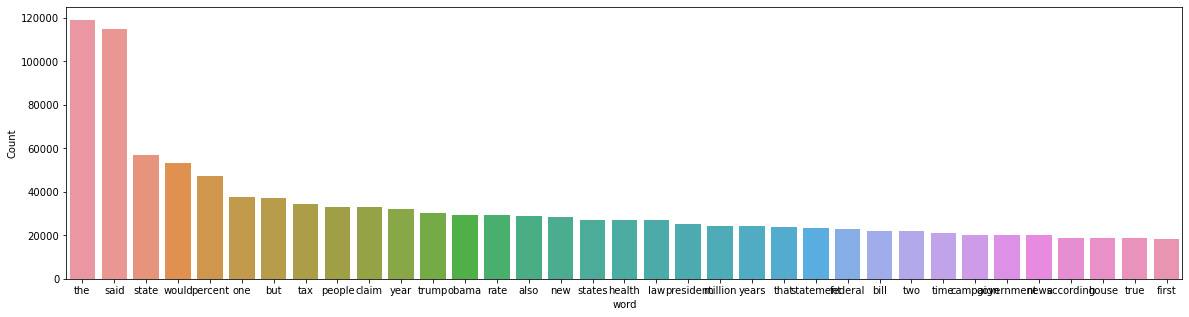

In [48]:
freq_words(pols, 35)

To further remove noise from the text we can use lemmatization from the spaCy library. It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

In [34]:
!python -m spacy download en

[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [36]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [37]:
tokenized_article = pd.Series(pols).apply(lambda x: x.split())
print(tokenized_article[1])

['recent', 'facebook', 'post', 'uses', 'video', 'clip', 'debate', 'president', 'donald', 'trump', 'joe', 'biden', 'raise', 'suspicions', 'something', 'visible', 'around', 'biden', 'wrist', 'previous', 'social', 'media', 'posts', 'sept', 'debate', 'wrongly', 'said', 'biden', 'wearing', 'wire', 'aid', 'debate', 'now', 'footage', 'cast', 'evidence', 'biden', 'human', 'this', 'proves', 'that', 'president', 'joe', 'biden', 'not', 'human', 'being', 'description', 'video', 'says', 'someone', 'narrating', 'clip', 'claims', 'something', 'looks', 'like', 'live', 'little', 'serpents', 'emerges', 'biden', 'suit', 'jacket', 'that', 'alive', 'narrator', 'says', 'kind', 'looks', 'like', 'shaking', 'head', 'little', 'bit', 'the', 'camera', 'pans', 'biden', 'narrator', 'says', 'that', 'human', 'people', 'this', 'post', 'flagged', 'part', 'facebook', 'efforts', 'combat', 'false', 'news', 'misinformation', 'news', 'feed', 'read', 'partnership', 'facebook', 'the', 'clip', 'used', 'facebook', 'video', 'com

In [ ]:
articles_2 = lemmatization(tokenized_article)
#print(articles_2[1]) # print lemmatized review

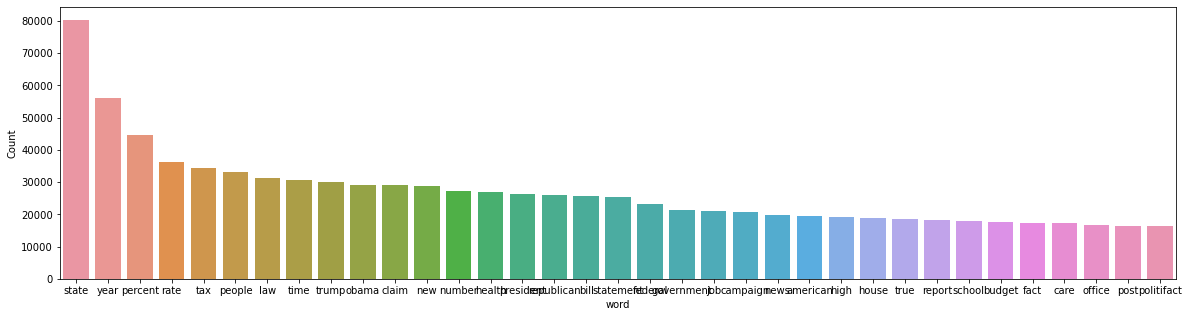

In [51]:
articles_3 = []
for i in range(len(articles_2)):
    articles_3.append(' '.join(articles_2[i]))

pol['curator_complete_article'] = articles_3

freq_words(pol['curator_complete_article'], 35)

## LDA model
We will start by creating the term dictionary of our corpus, where every unique term is assigned an index

In [56]:
dictionary = corpora.Dictionary(articles_2)

Then we will convert the list of articles (articles_2) into a Document Term Matrix using the dictionary prepared above.

In [57]:
doc_term_matrix = [dictionary.doc2bow(art) for art in articles_2]

It takes a while to run following code chunk

In [58]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [59]:
lda_model.print_topics()

[(0,
  '0.029*"tax" + 0.017*"health" + 0.015*"budget" + 0.013*"plan" + 0.013*"care" + 0.013*"year" + 0.011*"federal" + 0.010*"government" + 0.010*"taxis" + 0.010*"money"'),
 (1,
  '0.025*"law" + 0.015*"state" + 0.013*"gun" + 0.010*"crime" + 0.010*"immigration" + 0.009*"immigrant" + 0.009*"border" + 0.009*"people" + 0.009*"illegal" + 0.008*"case"'),
 (2,
  '0.026*"health" + 0.025*"abortion" + 0.017*"woman" + 0.011*"child" + 0.010*"medical" + 0.010*"death" + 0.009*"drug" + 0.009*"amp" + 0.009*"care" + 0.008*"life"'),
 (3,
  '0.014*"trump" + 0.012*"news" + 0.010*"obama" + 0.009*"post" + 0.008*"president" + 0.008*"story" + 0.008*"people" + 0.007*"time" + 0.006*"white" + 0.006*"clinton"'),
 (4,
  '0.033*"percent" + 0.031*"state" + 0.021*"year" + 0.018*"job" + 0.017*"number" + 0.016*"rate" + 0.013*"school" + 0.011*"high" + 0.009*"datum" + 0.008*"new"'),
 (5,
  '0.019*"republican" + 0.015*"state" + 0.014*"bill" + 0.014*"campaign" + 0.013*"vote" + 0.010*"election" + 0.009*"party" + 0.008*"hous

## Topics Visualization
To visualize our topics in a 2-dimensional space we will use the pyLDAvis library. This visualization is interactive in nature and displays topics along with the most relevant words.

In [62]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\forhad\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.033680  0.136506       1        1  19.352509
0     -0.047448  0.152264       2        1  18.544525
3     -0.062199 -0.205834       3        1  16.424179
5     -0.142439 -0.047684       4        1  16.228851
6     -0.047873  0.008659       5        1  12.038487
1      0.059767 -0.021803       6        1  10.955784
2      0.273872 -0.022108       7        1   6.455665, topic_info=         Term          Freq         Total Category  logprob  loglift
273       tax  33434.000000  33434.000000  Default  30.0000  30.0000
3825  percent  48181.000000  48181.000000  Default  29.0000  29.0000
53     health  29854.000000  29854.000000  Default  28.0000  28.0000
465       law  31514.000000  31514.000000  Default  27.0000  27.0000
197    budget  17714.000000  17714.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1185     test   1418.168582   2877.933657   Topic7  -5.6489   2.0325
116     state   2299.930876  77511.608606   Topic7  -5.1654  -0.7773
25      claim   1675.997262  27514.814404   Topic7  -5.4819  -0.0581
50      group   1579.057666  16794.678631   Topic7  -5.5415   0.3760
95     public   1483.056353  17199.087065   Topic7  -5.6042   0.2895

[539 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
8773      2  0.998065            aarp
7702      7  0.999865        abortion
1389      4  0.997878        absentee
289       1  0.067545  administration
289       2  0.213664  administration
...     ...       ...             ...
129       3  0.047246            year
129       4  0.075428            year
129       5  0.085109            year
129       6  0.071528            year
129       7  0.010173            year

[1252 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 6, 7, 2, 3])

### Works Cited
1 - https://www.politifact.com/who-pays-for-politifact/

2 - https://www.kaggle.com/shivkumarganesh/politifact-factcheck-data